# Wykorzystując rozkład PCA, ICA spróbować wyznaczyć składową oddechową z sygnału EKG.

### Zespół: Krzysztof Wicki, Tomasz Gruzdzis
### Projekt wykonywany na potrzeby przedmiotu "Obliczeniowe podstawy sztucznej inteligencji"


Notatnik prezentuje podsumowanie starań w wyznaczeniu składowej oddechowej z sygnału EKG, w literaturze nazywanej EDR z ang. "ECG Derived Respiration".

Przedstawione wyniki zebrane są dla wybranych przypadków VP02-VP38, z uwzglednieniem kolejnych prawidłowo zapisanych nagrań określonych w plikach Trigger.txt.

### 1. Import bibliotek

In [26]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy import interpolate
from scipy.fft import rfft, rfftfreq, irfft
import scipy.stats as stats
from sklearn.decomposition import KernelPCA, FastICA, PCA

from data_loader import Loader

Do uzyskania wyników wybraliśmy sierie pierwszych przypadków z wykorzystywanej bazy danych, baza oferuję więcej wpisów, jednak na potrzeby projektu obrana ilosć 186 nagrań (pomiary dla pacjęta podczas oglądania klipu) jest zadowalająca. 


In [17]:
case_dirs = [
    'VP02/', 'VP03/', 'VP05/', 'VP06/', 'VP08/', 'VP09/',
    'VP11/', 'VP12/', 'VP14/', 'VP15/', 'VP17/', 'VP18/',
    'VP20/', 'VP23/', 'VP24/', 'VP26/', 'VP27/', 'VP29/',
    'VP30/', 'VP32/', 'VP33/', 'VP35/', 'VP36/', 'VP38/',
]

Częstotliwość próbkowania ustalona na 100 Hz zgodnie z opisem bazy.

In [18]:
fs = 100

### 2. Wykorzystanie PCA

W przypadku PCA, do macierzy X zbieramy próbki dla całego uderzenia, co przybliżyliśmy na okno 80 próbek.

In [19]:
pca_window = 80
# Zainicjowanie słowników, dla zbiorczych wyników korelacji koherencji.
pca_coherence = {}
pca_correlation = {}

In [20]:
for case in case_dirs:
    # Załadowanie danych dla pacjenta
    loader = Loader(case_dir=case)
    ecg_data = loader.load_ECG()
    br_data = loader.load_BR()
    
    # Pobranie punktów granicznych, określających nagrania
    for index, row in loader.available_border_points.iterrows():
        if index == 0:
            continue
        try:
            res = loader.get_index_of_border_points(index, ecg_data)
            start = res['started']
            end = res['ended']
        except KeyError:
            continue
        
        # Selekcja szczytów R
        ecg_signal = ecg_data[start:end, 0]
        peakR, _ = ss.find_peaks(ecg_signal)
        prominences, _, _ = ss.peak_prominences(ecg_signal, peakR)
        selected = prominences > 0.5 * (np.min(prominences) + np.max(prominences))
        top = peakR[selected]
        
        # Stworzenie macierzy X o wymiarach n na m
        # gdzie n odpowiada ilości szczytów, a m wielkości okna.
        X_matrix_pca = []

        for peak in top:
            if peak < pca_window/2:
                continue
            vector = ecg_signal[(peak-int(pca_window/2)):(peak+int(pca_window/2))]
            if vector.size == pca_window:
                X_matrix_pca.append(vector)
        
        X_matrix_pca = np.asarray(X_matrix_pca)
        
        # Uzyskany sygnał EDR będzie odpowiadał każdemu załamkowi,
        # więc przycinamy obrany sygnał EKG od pierwszego do ostatniego załamka
        ecg_signal_croped = ecg_data[start+top[1]:start+top[-1], 0]
        time = np.arange(ecg_signal_croped.size) / fs
        
        # Implementacja PCA, pozwalająca wyciągnąć wspomniany EIGENVECTOR,
        # co było znacząco utrudnione w implementacji Sklearn.
        centered_matrix = X_matrix_pca - X_matrix_pca.mean(axis=1)[:, np.newaxis]
        cov = np.dot(centered_matrix, centered_matrix.T)
        eigvals, eigvecs = np.linalg.eig(cov)
        
        # Sortowanie wektorów własnych względem wartości własnych
        sorted_index = np.argsort(eigvals)[::-1] 
        sorted_eigenvalue = eigvals[sorted_index]
        sorted_eigenvectors = eigvecs[:,sorted_index]
        
        # Interpolacja funkcji do rozmiarów sygnału przyciętego
        ff = ss.resample(sorted_eigenvectors[0], ecg_signal_croped.size)
        f = interpolate.interp1d(time, ff)
        pca1 = f(time)
        
        # wyodrębnienie referencyjnego sygnału oddechowego
        br_signal = br_data[start+top[1]:start+top[-1], 0]
        try:
            # Obliczenie Koherencji
            _, Cxy = ss.coherence(pca1, br_signal, fs, window='hamming', nperseg=(pca1.size/8), nfft=16384)

            key = '{0}_{1}'.format(case, index)
            pca_coherence[key] = np.max(Cxy)
            
            # Obliczenie Korelacji
            r, p = stats.pearsonr(pca1, br_signal)
            pca_correlation[key] = abs(r)
        except ValueError:
            continue


In [21]:
pca_correlation

{'VP02/_4': 0.009316020895236065,
 'VP02/_6': 0.02918433279874739,
 'VP02/_15': 0.11289598739293241,
 'VP03/_13': 0.09043232027015459,
 'VP05/_1': 0.17533961397758915,
 'VP05/_5': 0.05777566639027728,
 'VP05/_11': 0.08365946629904399,
 'VP06/_2': 0.024610154778570793,
 'VP06/_4': 0.10828320006973952,
 'VP06/_5': 0.21668838616648842,
 'VP06/_6': 0.06402582673809962,
 'VP06/_7': 0.06513525383931791,
 'VP06/_8': 0.14649177810479883,
 'VP06/_9': 0.03513549128462984,
 'VP06/_10': 0.096139417741571,
 'VP06/_11': 0.17625621660495205,
 'VP06/_12': 0.09515342229699328,
 'VP06/_13': 0.4611077295081959,
 'VP06/_14': 0.17467310064459574,
 'VP06/_15': 0.032988062771610434,
 'VP06/_16': 0.12714029661752246,
 'VP06/_17': 0.04280324787290986,
 'VP08/_1': 0.04326556085780639,
 'VP08/_2': 0.05222437628440474,
 'VP08/_6': 0.16584011385224706,
 'VP08/_8': 0.052674115901734236,
 'VP08/_9': 0.050049365631948076,
 'VP08/_12': 0.04467989691060521,
 'VP08/_13': 0.10571345940017807,
 'VP08/_14': 0.0007773991340

In [22]:
pca_coherence

{'VP02/_4': 0.28987192487238156,
 'VP02/_6': 0.3316405937977464,
 'VP02/_15': 0.3523349572755034,
 'VP03/_13': 0.33060198153121656,
 'VP05/_1': 0.48917394044167667,
 'VP05/_5': 0.4594889752438338,
 'VP05/_11': 0.4922613250704864,
 'VP06/_2': 0.44304741742154247,
 'VP06/_4': 0.5230550721140939,
 'VP06/_5': 0.45696898621048065,
 'VP06/_6': 0.4814116742212972,
 'VP06/_7': 0.42431265946900165,
 'VP06/_8': 0.3905250674996087,
 'VP06/_9': 0.5046347323070184,
 'VP06/_10': 0.4049309537726611,
 'VP06/_11': 0.3996078287934397,
 'VP06/_12': 0.38200009134229673,
 'VP06/_13': 0.5254674057056978,
 'VP06/_14': 0.510382704060607,
 'VP06/_15': 0.6440684110216239,
 'VP06/_16': 0.3890320669914118,
 'VP06/_17': 0.5561828478931976,
 'VP08/_1': 0.48914886630464516,
 'VP08/_2': 0.3549908202759026,
 'VP08/_6': 0.49744459688512993,
 'VP08/_8': 0.4499241342860314,
 'VP08/_9': 0.4772807468459802,
 'VP08/_12': 0.45211122441375834,
 'VP08/_13': 0.49015458093949965,
 'VP08/_14': 0.41962599677814466,
 'VP09/_2': 0.6

### 3. Wykorzystanie ICA

W odróżnieniu od metody PCA, w publikacjach dotyczących zastosowania ICA, pobierano jedynie załamek QRS, którego wartości zapisywano do macierzy X. Przybliżenie okna wynosi w tym przypadku 20 próbek dla samego QRS.

In [23]:
ica_window = 20
# Zainicjowanie słowników, dla zbiorczych wyników korelacji koherencji.
ica_coherence = {}
ica_correlation = {}

In [31]:
for case in case_dirs:
    loader = Loader(case_dir=case)
    ecg_data = loader.load_ECG()
    br_data = loader.load_BR()
    
    # Pobranie punktów granicznych, określających nagrania
    for index, row in loader.available_border_points.iterrows():
        if index == 0:
            continue
        
        try:
            res = loader.get_index_of_border_points(index, ecg_data)
            start = res['started']
            end = res['ended']
        except KeyError:
            continue
        ecg_signal = ecg_data[start:end, 0]
        
        # Selekcja szczytów R
        peakR, _ = ss.find_peaks(ecg_signal)
        prominences, _, _ = ss.peak_prominences(ecg_signal, peakR)
        selected = prominences > 0.5 * (np.min(prominences) + np.max(prominences))
        top = peakR[selected]
        
        # Stworzenie macierzy X o wymiarach n na m
        # gdzie n odpowiada ilości szczytów, a m wielkości okna.
        X_matrix_ica = []
        
        for peak in top:
            if peak < ica_window/2:
                continue
            vector = ecg_signal[(peak-int(ica_window/2)):(peak+int(ica_window/2))]
            if vector.size == ica_window:
                X_matrix_ica.append(vector)
        
        X_matrix_ica = np.asarray(X_matrix_ica)
        
        # Uzyskany sygnał EDR będzie odpowiadał każdemu załamkowi,
        # więc przycinamy obrany sygnał EKG od pierwszego do ostatniego załamka
        ecg_signal_croped = ecg_data[start+top[1]:start+top[-1], 0]
        time = np.arange(ecg_signal_croped.size) / fs
        
        # Wedle zebranych publikacji przed zastosowaniem ICA, wykorzystywane zostaje PCA.
        # PCA pozwala nam na redukcje do 10 próbek, na każdy załamek R
        pca_for_ica = PCA(n_components=10, whiten=True)
        buffer = pca_for_ica.fit_transform(X_matrix_ica)
        ica10 = FastICA(n_components=10)
        ica10.fit(buffer)
        
        # Powstała macierz jest wymiaru n na 10, gdzie n to ilośc załamków R.
        trf = ica10.transform(buffer)
        
        # Kolejnym krokiem jest selekcja komponentu o największej
        # amplitudzie w przedziale częstotliwości oddechowej.
        max_value = 0
        edr_ic = 0
        # Częstotliwość próbkowana jest pomniejszona - 1 punkt na okno
        sample_rate = int(fs / ica_window)

        for i in range(10):
            yf = rfft(trf.T[i])
            xf = rfftfreq(trf.T[i].size, (1. / sample_rate))

            s_idx = np.where(xf > 0.2)
            s_idx = s_idx[0][0]
            e_idx = np.where(xf < 0.5)
            e_idx = e_idx[0][-1]
            
            candidate = np.max(abs(yf[s_idx:e_idx]))
            if candidate > max_value:
                max_value = candidate
                edr_ic = i
                
        yf = rfft(trf.T[edr_ic])
        xf = rfftfreq(trf.T[edr_ic].size, (1. / sample_rate))
        # Filtracja o parametrach zalecanych w publikacji
        sos = ss.butter(2, [0.0666, 0.6], 'bandpass', output='sos')
        filtered = ss.sosfilt(sos, yf)
        
        # Interpolacja funkcji do rozmiarów sygnału przyciętego
        ica_edr = irfft(filtered)
        ica_edr = ss.resample(ica_edr, ecg_signal_croped.size)
        f = interpolate.interp1d(time, ica_edr)
        ica_edr = f(time)
          
        br_signal = br_data[start+top[1]:start+top[-1], 0]
        try:
            # Obliczenie Koherencji

            _, Cxy = ss.coherence(ica_edr, br_signal, fs, window='hamming', nperseg=(ica_edr.size/8), nfft=16384)

            key = '{0}_{1}'.format(case, index)
            ica_coherence[key] = np.max(Cxy)
            
            # Obliczenie Korelacji
            r, p = stats.pearsonr(ica_edr, br_signal)
            ica_correlation[key] = abs(r)
        except ValueError:
            continue


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
16 38
16 38
16 38
16 38
16 38
16 38
16 38
16 38
16 38
16 38
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
98 244
98 244
98 244
98 244
98 244
98 244
98 244
98 244
98 244
98 244


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
14 33
14 33
14 33
14 33
14 33
14 33
14 33
14 33
14 33
14 33
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


16 39
16 39
16 39
16 39
16 39
16 39
16 39
16 39
16 39
16 39


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
77 191
77 191
77 191
77 191
77 191
77 191
77 191
77 191
77 191
77 191
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
104 258
104 258
104 258
104 258
104 258
104 258
104 258
104 258
104 258
104 258
18 44
18 44
18 44
18 44
18 44
18 44
18 44
18 44
18 44
18 44
6 14
6 14
6 14
6 14
6 14
6 14
6 14
6 14
6 14
6 14
6 12
6 12
6 12
6 12
6 12
6 12
6 12
6 12
6 12
6 12
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
162 403
162 403
162 403
162 403
162 403
162 403
162 403
162 403
162 403
162 403


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


15 35
15 35
15 35
15 35
15 35
15 35
15 35
15 35
15 35
15 35
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


18 44
18 44
18 44
18 44
18 44
18 44
18 44
18 44
18 44
18 44
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
120 298
120 298
120 298
120 298
120 298
120 298
120 298
120 298
120 298
120 298


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 7
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


16 38
16 38
16 38
16 38
16 38
16 38
16 38
16 38
16 38
16 38


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
95 235
95 235
95 235
95 235
95 235
95 235
95 235
95 235
95 235
95 235
17 41
17 41
17 41
17 41
17 41
17 41
17 41
17 41
17 41
17 41


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
5 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
101 250
101 250
101 250
101 250
101 250
101 250
101 250
101 250
101 250
101 250


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


17 40
17 40
17 40
17 40
17 40
17 40
17 40
17 40
17 40
17 40
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 6
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
3 7
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 11
5 11
5 11
5 11
5 11
5 11
5 11
5 11
5 11
5 11


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
5 10
22 53
22 53
22 53
22 53
22 53
22 53
22 53
22 53
22 53
22 53
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 8
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9
4 9


C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Tomasz\Anaconda3\envs\yolo\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [32]:
ica_coherence

{'VP02/_4': 0.3888383944786587,
 'VP02/_6': 0.35738411305910406,
 'VP02/_15': 0.4016800035015009,
 'VP03/_13': 0.6356218939436555,
 'VP05/_1': 0.5077587976992789,
 'VP05/_5': 0.528474135201136,
 'VP05/_11': 0.40337686296760855,
 'VP06/_2': 0.4104808343160696,
 'VP06/_4': 0.5345990993468601,
 'VP06/_5': 0.4507338895592974,
 'VP06/_6': 0.34710668613302725,
 'VP06/_7': 0.6023430066485282,
 'VP06/_8': 0.5983682031708888,
 'VP06/_9': 0.46617422514634504,
 'VP06/_10': 0.3816612307082339,
 'VP06/_11': 0.6260819289446665,
 'VP06/_12': 0.43472834062628524,
 'VP06/_13': 0.6077986759940944,
 'VP06/_14': 0.49099272726405185,
 'VP06/_15': 0.4570367619311643,
 'VP06/_16': 0.4212416390797694,
 'VP06/_17': 0.5905006905917786,
 'VP08/_1': 0.4032204199080963,
 'VP08/_2': 0.4541527623634598,
 'VP08/_6': 0.31357682624815203,
 'VP08/_8': 0.3164374356797793,
 'VP08/_9': 0.442292659541176,
 'VP08/_12': 0.4556061891840781,
 'VP08/_13': 0.6474515352679189,
 'VP08/_14': 0.3701419157143865,
 'VP09/_2': 0.4897336

In [33]:
ica_correlation

{'VP02/_4': 0.2501338355779151,
 'VP02/_6': 0.12974072393274144,
 'VP02/_15': 0.13794898165219438,
 'VP03/_13': 0.17318946644413513,
 'VP05/_1': 0.040999129509485,
 'VP05/_5': 0.022840537372090505,
 'VP05/_11': 0.1348773337373847,
 'VP06/_2': 0.10183618351239256,
 'VP06/_4': 0.06698408325769238,
 'VP06/_5': 0.10993192091943109,
 'VP06/_6': 0.12867130342629476,
 'VP06/_7': 0.07282364947136226,
 'VP06/_8': 0.3244636736141969,
 'VP06/_9': 0.06692593585091383,
 'VP06/_10': 0.04217650275705449,
 'VP06/_11': 0.13892035150097068,
 'VP06/_12': 0.01747654662890981,
 'VP06/_13': 0.011633555288867906,
 'VP06/_14': 0.07892393567074846,
 'VP06/_15': 0.021602980521604698,
 'VP06/_16': 0.05400341157332978,
 'VP06/_17': 0.007448119184986451,
 'VP08/_1': 0.01659791227822864,
 'VP08/_2': 0.01566897017115812,
 'VP08/_6': 0.17804429938934677,
 'VP08/_8': 0.053713821058199974,
 'VP08/_9': 0.09464834857696501,
 'VP08/_12': 0.17593728199456665,
 'VP08/_13': 0.3240490082959215,
 'VP08/_14': 0.0934693800496805

### 4. Wizualizacja wyników

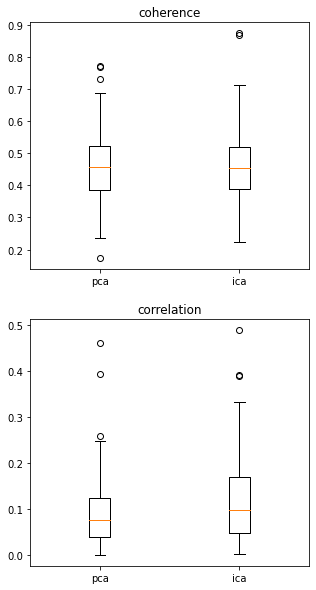

In [41]:
# Zebranie wartości korelacji i koherencji

pca_coherence_values = np.array(list(pca_coherence.values()))
ica_coherence_values = np.array(list(ica_coherence.values()))

pca_correlation_values = np.array(list(pca_correlation.values()))
ica_correlation_values = np.array(list(ica_correlation.values()))

data_coherence = [pca_coherence_values, ica_coherence_values]
data_correlation = [pca_correlation_values, ica_correlation_values]

fig, ax = plt.subplots(2, figsize = [5, 10])
ax[0].boxplot(data_coherence)
ax[0].set_title('coherence')
ax[0].set_xticklabels(['pca', 'ica'])

ax[1].boxplot(data_correlation)
ax[1].set_title('correlation')
ax[1].set_xticklabels(['pca', 'ica'])

plt.show()